In [1]:
import pickle
from pathlib import Path
import haiku as hk
import jax.numpy as jnp
from jaxpm.nn import CNN
from jax.experimental.ode import odeint
import jax_cosmo as jc
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
sys.path.append("../")

from read_data import get_data, load_datasets


## Check data stored in files

In [5]:
mesh_lr = 32
mesh_hr = 64
data_dir = Path(f"/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/data/matched_{mesh_lr}_{mesh_hr}/")
box_size = 256.0
n_sims = 1

pos_hr, vel_hr, pot_hr = get_data(
    data_dir=data_dir,
    n_mesh=mesh_hr,
    downsampling_factor=None,
    box_size=box_size,
)
pos_lr, vel_lr, pot_lr = get_data(
    data_dir,
    n_mesh=mesh_lr,
    idx=0,
    box_size=box_size,
)
print(pos_hr.shape)
print(pos_lr.shape)

(25, 262144, 3)
(25, 262144, 3)


AttributeError: PathCollection.set() got an unexpected keyword argument 'markersize'

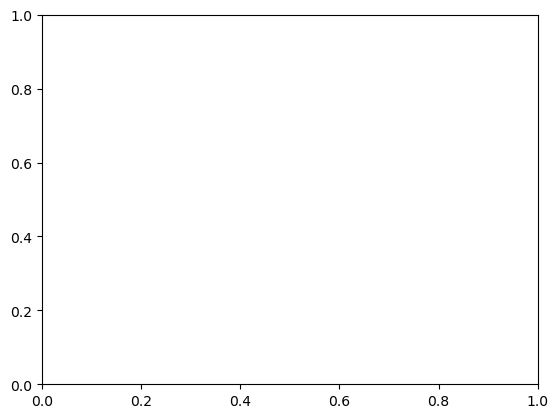

In [7]:
plt.scatter(
    pot_lr[-1].flatten(),
    pot_hr[-1].flatten(),
    marker='o',
    s=1
)

(64, 64, 64)


Text(0.5, 1.0, 'HR')

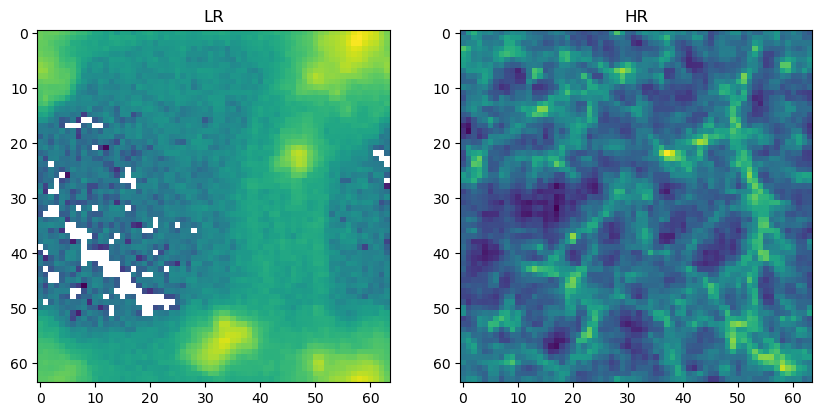

In [4]:
mesh_plot = 64 
delta_hr = cic_paint(jnp.zeros((mesh_plot, mesh_plot, mesh_plot)), pos_hr[-1]*mesh_plot)
delta_lr = cic_paint(jnp.zeros((mesh_plot, mesh_plot, mesh_plot)), pos_lr[-1]*mesh_plot)
print(delta_hr.shape)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow((delta_lr[:,:,:]).sum(axis=0),
           norm=LogNorm())
ax[1].imshow((delta_hr[:,:,:]).sum(axis=0),
           norm=LogNorm())
ax[0].set_title("LR")
ax[1].set_title("HR")

In [16]:
delta_hr = cic_paint(jnp.zeros((mesh_plot, mesh_plot, mesh_plot)), pos_hr[-1]*64)
delta_lr = cic_paint(jnp.zeros((mesh_plot, mesh_plot, mesh_plot)), pos_lr[-1]*32)

In [17]:
np.std(delta_hr) / np.std(delta_lr)

Array(0.783507, dtype=float32)

In [18]:
np.sqrt(2)

1.4142135623730951

In [19]:
64**3 / 32**3

8.0

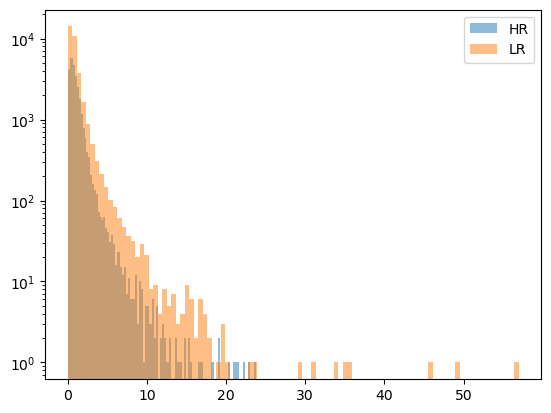

In [20]:
_ = plt.hist(delta_hr.flatten(), bins=100, alpha=0.5, label="HR", log=True)
_ = plt.hist(delta_lr.flatten(), bins=100, alpha=0.5, label="LR", log=True)
plt.legend()

## Check dataset as read by network

In [21]:
train_ds, val_ds = load_datasets(1,1,64,32,data_dir)

In [10]:
hr_ds = train_ds[0]['hr']
lr_ds = train_ds[0]['lr']

(32, 32, 32)


Text(0.5, 1.0, 'HR')

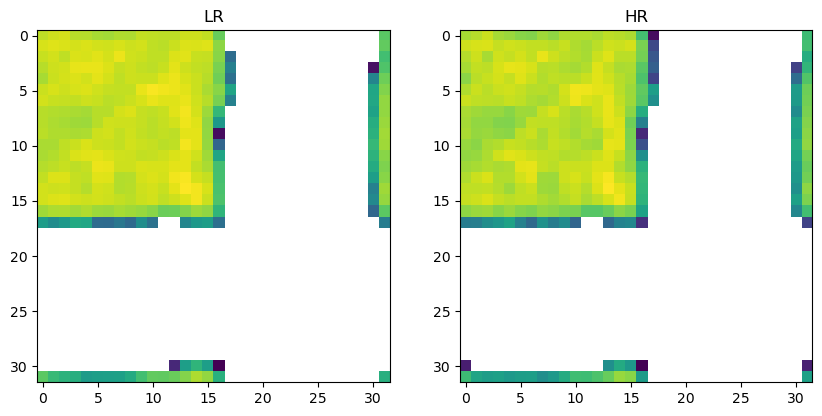

In [11]:
mesh_plot = 32 
delta_hr = cic_paint(jnp.zeros((mesh_plot, mesh_plot, mesh_plot)), hr_ds.positions[-1]*mesh_plot)
delta_lr = cic_paint(jnp.zeros((mesh_plot, mesh_plot, mesh_plot)), lr_ds.positions[-1]*mesh_plot)
print(delta_hr.shape)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow((delta_lr[:,:,:]).sum(axis=0),
           norm=LogNorm())
ax[1].imshow((delta_hr[:,:,:]).sum(axis=0),
           norm=LogNorm())
ax[0].set_title("LR")
ax[1].set_title("HR")

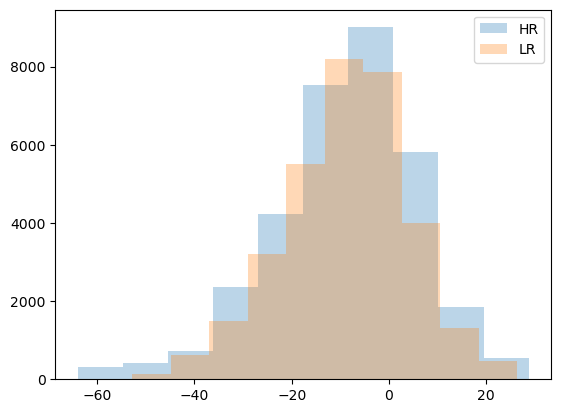

In [12]:
_ = plt.hist(hr_ds.potential[-1], alpha=0.3, label='HR')
_ = plt.hist(lr_ds.potential[-1], alpha=0.3, label='LR')
plt.legend()

Text(0, 0.5, 'LR Pot')

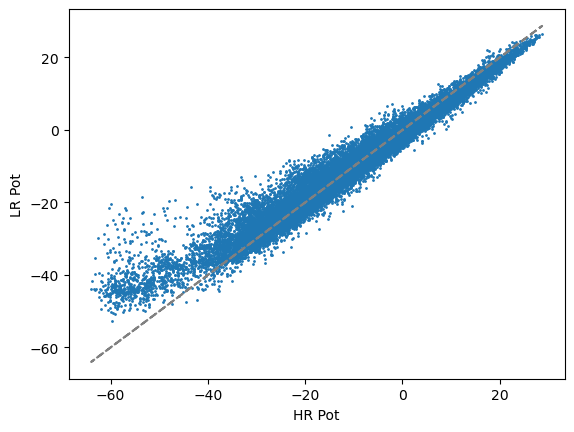

In [13]:
plt.scatter(
    hr_ds.potential[-1],
    lr_ds.potential[-1],
    marker='o', s=1,
)
plt.plot(
    hr_ds.potential[-1],
    hr_ds.potential[-1],
    linestyle='dashed', color='gray'
)
plt.xlabel("HR Pot")
plt.ylabel("LR Pot")

In [33]:
# Compare Pk (is downsampling doing something wrong?)